In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
from scripts import data_setup, data_acquisition, engine, predict
from pathlib import Path
from tqdm.auto import tqdm
from random import sample
from torch.utils.tensorboard import SummaryWriter
from IPython.display import Latex

c:\Users\warre\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup Hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = 0

In [3]:
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi_20%"
train_dir = image_path / "train"
test_dir = image_path /"test"

In [4]:
# Setup manual transforms as required in the ViT

manual_transforms = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

In [5]:
# This code cell can be used to download a dataset from a URL and extract it to a specified directory

# This is a smaller version of the Food101 dataset

# data_acquisition.acquire_data(image_path=image_path,
#                               url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
#                               zip_name = "pizza_steak_sushi_20%")

# train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(data_dir=image_path,
#                                                                                train_transform=manual_transforms,
#                                                                                test_transform=manual_transforms,
#                                                                                batch_size=BATCH_SIZE,
#                                                                                num_workers=NUM_WORKERS)

In [6]:
# Obtain required dataset. This may be commented out and the cell may be run again to download the dataset from a URL

train_dataset = datasets.CIFAR10(root = data_path,
                                  train = True,
                                  transform = manual_transforms,
                                  download = True)
test_dataset = datasets.CIFAR10(root = data_path,
                                train = False,
                                transform = manual_transforms,
                                download = True)

# Setup the dataloaders

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset = test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=NUM_WORKERS)

class_names = train_dataset.classes

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Inspect our data

print(f"Number of train images: {len(train_dataset)}, Number of test images: {len(test_dataset)}\n")
print(f"Number of train batches: {len(train_dataloader)}, Number of test batches: {len(test_dataloader)}\n")
print(f"{len(train_dataset) // BATCH_SIZE} batches in the train dataloader expected and {len(test_dataset) // BATCH_SIZE} batches in the test dataloader expected.\nNote: This may not be exactly equal and may differ by 1 batch due to rounding off\n")
print(f"Classes: {class_names}")

Number of train images: 50000, Number of test images: 10000

Number of train batches: 1563, Number of test batches: 313

1562 batches in the train dataloader expected and 312 batches in the test dataloader expected.
Note: This may not be exactly equal and may differ by 1 batch due to rounding off

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


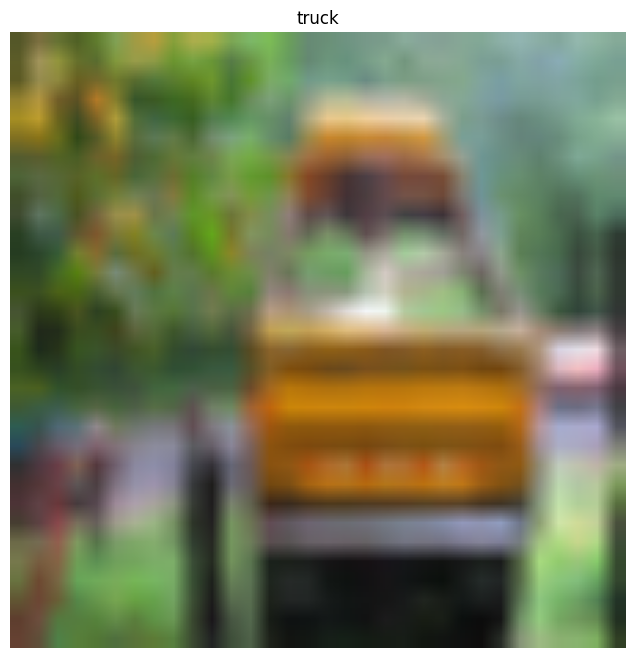

In [8]:
# Visualizing a single image
first_image_batch, first_label_batch = next(iter(train_dataloader))
random_image_index = torch.randint(low = 0, high = len(first_image_batch), size=(1,)).item()

random_image = first_image_batch[random_image_index]
random_label = first_label_batch[random_image_index].item()

plt.figure(figsize = (12,8))
plt.imshow(random_image.permute(1,2,0))
plt.title(class_names[random_label])
plt.axis(False)
plt.show()

### Study of equations

#### Equation 1

\begin{align}
\mathbf{z}_0=[\mathbf{x}_{\mathrm{class}}; \mathbf{x}_p^1\mathbf{E}; \mathbf{x}_p^2\mathbf{E};\cdots; \mathbf{x}_p^N\mathbf{E}]+\mathbf{E}_{pos}
\end{align}

is the first equation. Here, we compute the input to the transformer encoder. 
\begin{align}
\mathbf{x}_{\mathrm{class}} 
\end{align}
is a learnable class token
\begin{align}
\mathbf{x}_p^i
\end{align}
is the i-th patch embedding obtained from the linear projection of the flattened image
\begin{align}
\mathbf{E}_{pos}^i
\end{align}
is the positional embedding corresponding to the i-th patch position


#### Equation 2

The second euqation describes the multi-head self attention (MSA). MSA mechanism applies self-attention multiple times in parallel.

Attention is when a token focues on another token and an attention head is a single instance of the self-attention mechanism.

First, 3 learned projection matrices are used to compute the matrices for Queires(Q), Keys(K) and Values(V), where each matrix is of an embedding dimension d Then, attention is calculated as
\begin{align}
Attention(Q,K,V) = softmax(\dfrac{QK^T}{\sqrt{d_k}})V
\end{align}

Softmax is used to make sure all attention scores are positive and sum up to 1. Attention scores are used to compute a weighted sum of the values V.

In MSA, we apply self-attention multiple times in parallel using different learned projection matrices for each head. This allows the model to capture different aspects of the relationship between tokens. Then, the attention heads are concatenated.

The second equation is,
\begin{align}
\mathbf{z^{\prime}}_\ell=\mathrm{MSA}(\mathrm{LN}(\mathbf{z}_{\ell-1}))+\mathbf{z}_{\ell-1}
\end{align}


#### Equation 3

The third equation describes the MLP part of the ViT. It is a feedforward neural network and it operates on each token independantly.
\begin{align}
z_{l+1} = MLP(LN(z^{\prime}_l)) + z^{\prime}_l
\end{align}

The activatoin function used here is GELU.

#### Equation 4

The final equation is the normalization of the previous layer. This summarizes the previous layers

### Replication

First we take a look at patch embeddings. If data can be represented in a learnable way, it is much easier to train a model. Here we use patches of size 16\*16. The number of patches depends on the original size (which is 224\*244\*3 here)

In [9]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = (height * width) // (patch_size ** 2)
print(f"Number of patches for image of size {height}x{width} with patch size {patch_size}: {number_of_patches}")

Number of patches for image of size 224x224 with patch size 16: 196


In [10]:
embedding_layer_input_shape = (height, width, color_channels)
embegging_layer_output_shape = (number_of_patches, patch_size **2 * color_channels)

print(f"Input shape to embedding layer: {embedding_layer_input_shape}")
print(f"Output shape from embedding layer: {embegging_layer_output_shape}")

Input shape to embedding layer: (224, 224, 3)
Output shape from embedding layer: (196, 768)


### Converting a single image into patches

In this section, we take the previous random image and convert it to patches, and in this example, a 224\*224 image to many images of size 16\*16

In [11]:
# First, we create an array of zeros with the shape of the number of patches, patch size, patch size, and color channels.
# The patch size, patch size represents the height and width of the patch and the color channels represent the number of channels in the image (3 for RGB).
random_image_permuted = random_image.permute(1,2,0) # We permute the image to have the color channels at the end
rows = np.zeros ((height // patch_size, patch_size, width, color_channels))
for i in range(height // patch_size):
    row = random_image_permuted[i * patch_size: (i + 1) * patch_size, :,:]
    rows[i] = row
print(f"Shape of rows: {rows.shape}")

Shape of rows: (14, 16, 224, 3)


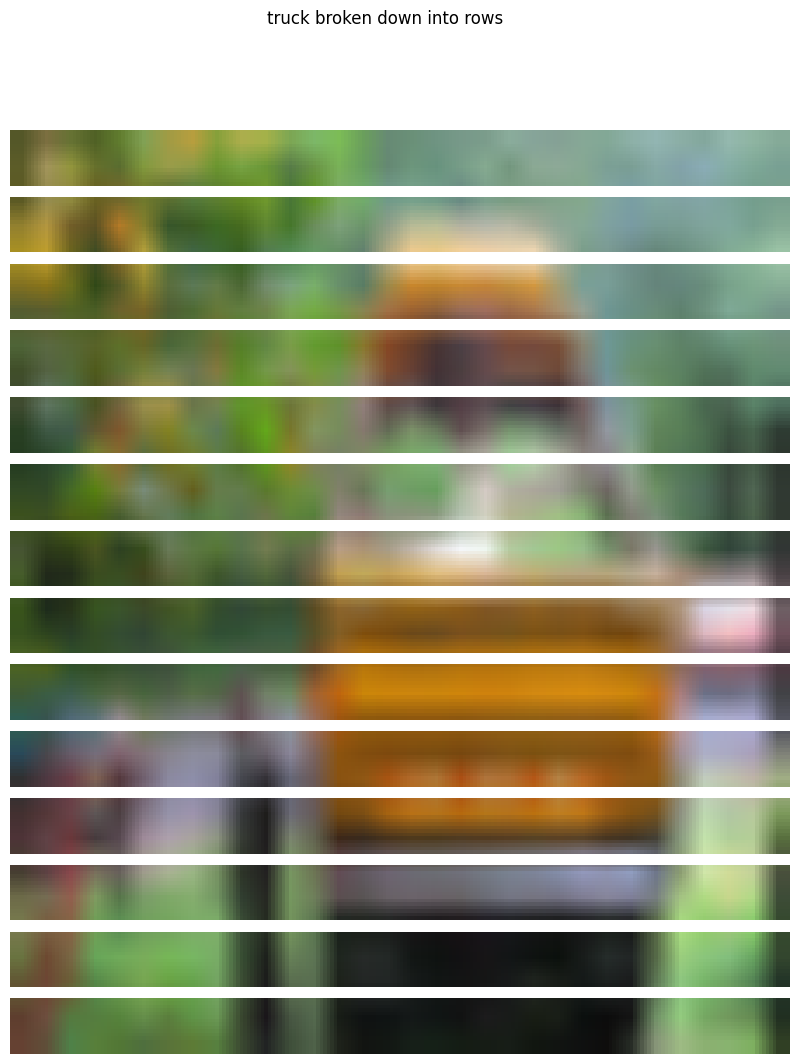

In [12]:
fig, axes = plt.subplots(nrows = height // patch_size, 
                         ncols = 1, 
                         figsize = (12, 12))
fig.suptitle(f"{class_names[random_label]} broken down into rows")
for i,row in enumerate(rows):
    axes[i].imshow(row)
    axes[i].axis(False)
plt.show()

Above, we have seperated the rows into rows of height 1. Now, each row has to be seperated into patches of size 16\*16

In [13]:
patches = np.zeros((number_of_patches, patch_size, patch_size, color_channels))
for i,row in enumerate(rows):
    for j in range(width // patch_size):
        patch = row[:, j * patch_size: (j + 1) * patch_size,:]
        patches[i * (width // patch_size) + j] = patch
print(patches[0].shape)

(16, 16, 3)


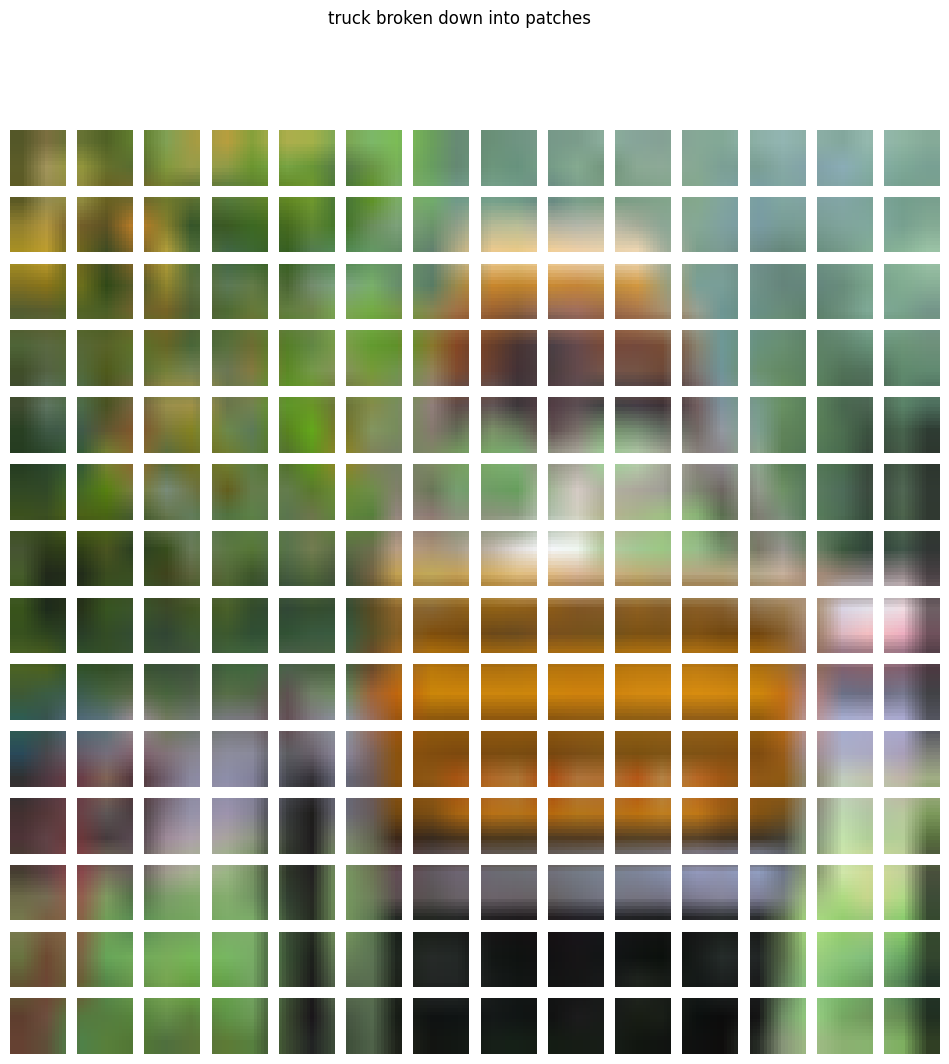

In [14]:
fig, axes = plt.subplots(nrows = height // patch_size, 
                         ncols = width // patch_size, 
                         figsize = (12, 12))
fig.suptitle(f"{class_names[random_label]} broken down into patches")
for i in range(height // patch_size):
    for j in range(width // patch_size):
        axes[i,j].imshow(patches[i * width // patch_size + j])
        axes[i,j].axis(False)
plt.show()

### Creating patches with torch.nn.Conv2d

According to the ViT paper, 

`As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection E (Eq. 1) is applied to patches extracted from a CNN feature map. As a special case, the patches can have spatial size 1×1, which means that the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension. The classification input embedding and position embeddings are added as described above.`

Therefore, instead of just breaking the image into 16\*16 blocks, we can use a 2D convolutional layer to split the image and create a learnable embedding.

To create patches of required size, we set the kernel size to P and the stride also to P

In [15]:
conv2d = nn.Conv2d(in_channels = 3, # 3 for RGB
                   out_channels = 768, # 768 is the number of hidden units in the ViT base model
                   kernel_size = patch_size, 
                   stride = patch_size,
                   padding = 1)


In [16]:
image_after_convolution = conv2d(random_image.unsqueeze(0)) # We add a batch dimension
print(f"Shape of image after convolution: {image_after_convolution.shape}")

Shape of image after convolution: torch.Size([1, 768, 14, 14])


Random indices = [679, 556, 99, 182, 487]


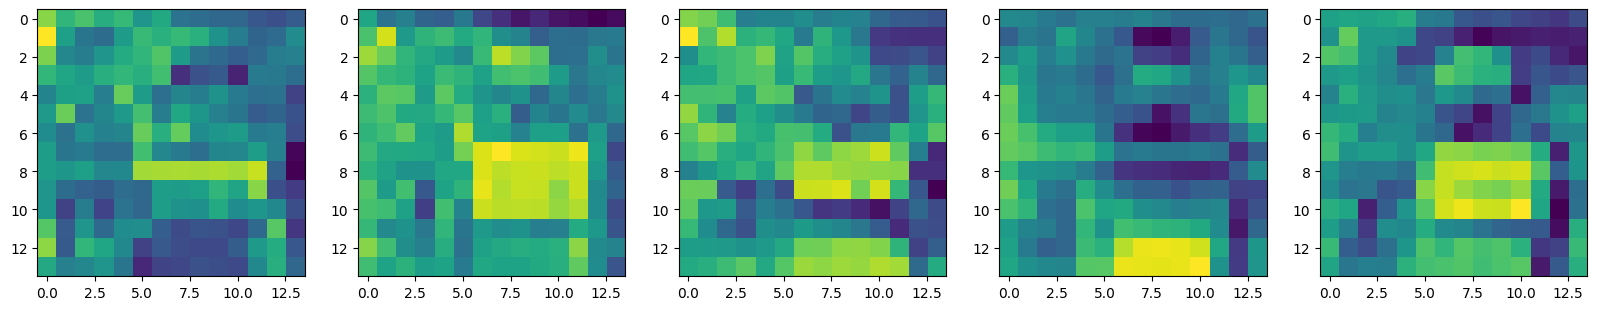

In [17]:
random_indices = sample(population=range(768),
                        k = 5)
print(f"Random indices = {random_indices}")
fig, axes = plt.subplots(nrows = 1,
                         ncols = 5,
                         figsize = (20, 12))
squeezed_image = image_after_convolution.squeeze(dim = 0)
for i, index in enumerate(random_indices):
    axes[i].imshow(squeezed_image[index].detach().numpy())

### Flatten

Next, we need to flatten the learned embeddings. This needs to be done outside the number of out shannels dimensions. That is, we still want to make sure that the outermost shape is 768 as in the case of ViT base

In [18]:
flattenLayer = nn.Flatten(start_dim = 2, 
                          end_dim = 3)
# Only the 14x14 patches are flattened

In [19]:
flattened_patches = flattenLayer(image_after_convolution)

In [20]:
print(f"Shape of flattened patches: {flattened_patches.shape}")
# We have successfully flattened the patches while maintaining the batch size and the number of patches

Shape of flattened patches: torch.Size([1, 768, 196])


Random indices = [61, 340, 330, 753, 138]


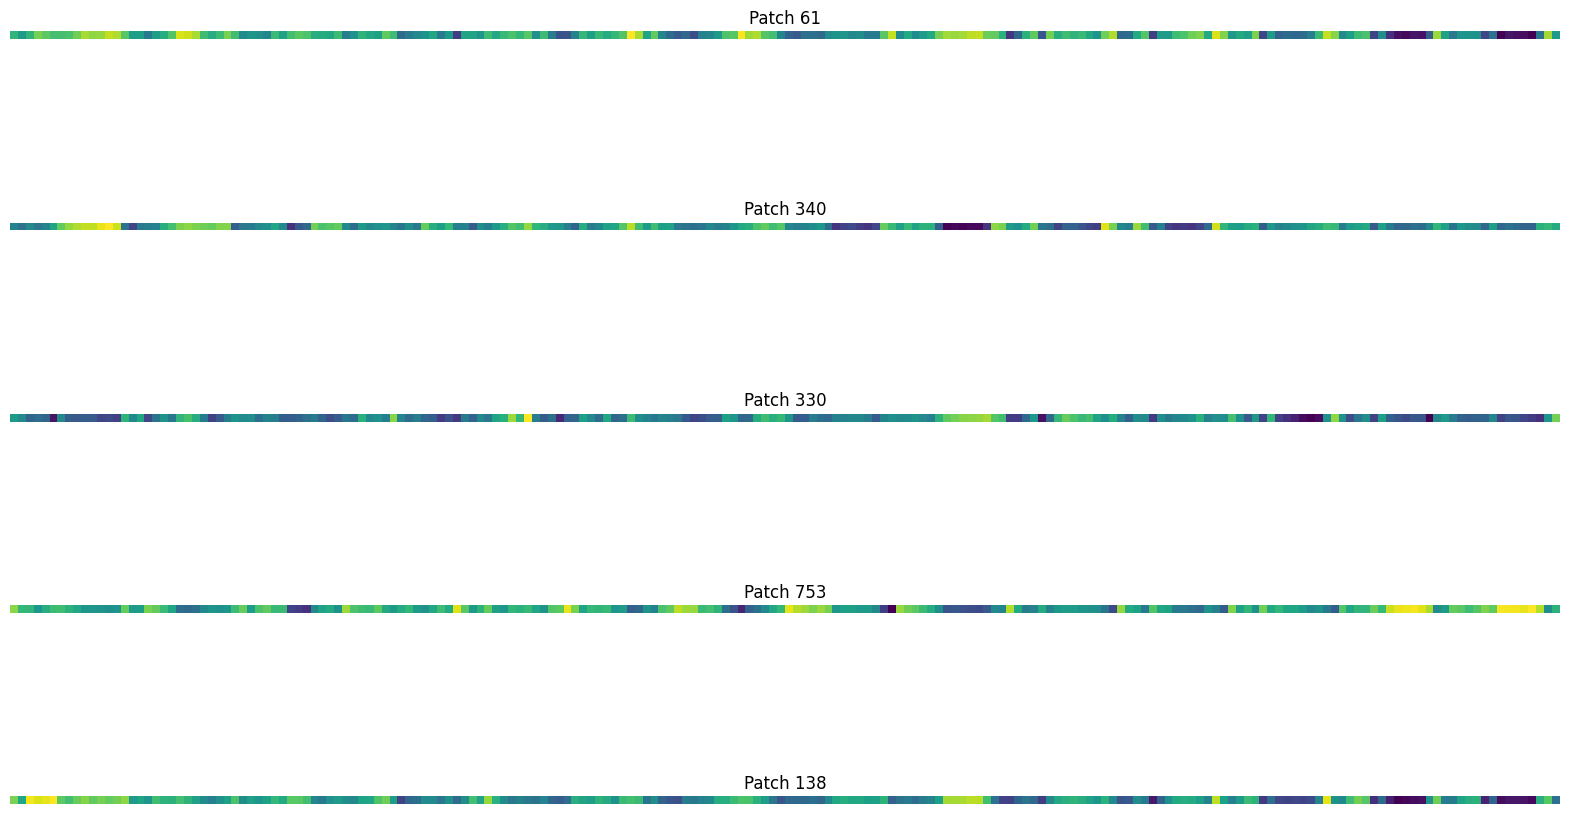

In [41]:
random_indices = sample(population=range(768),
                        k = 5)
print(f"Random indices = {random_indices}")
fig, axes = plt.subplots(nrows = 5,
                         ncols = 1,
                         figsize = (20, 12))
for i, index in enumerate(random_indices):
    patch_plot = flattened_patches[0][index].unsqueeze(dim = 0) # 0 is used to index into the first 'batch'
    axes[i].imshow(patch_plot.detach().numpy())
    axes[i].axis(False)
    axes[i].set_title(f"Patch {index}")
plt.show()

The reason for flattening is because, originally, the transformer was designed to work with text and hence by transforming, we are essentially converting our 2D image into a 1D text representation

### Creating a class for creating patch embeddings

In this section, we create a class out of the code above. We let it inherit from nn.Module so that we can easily use it in a pytorch model

In [22]:
class PatchEmbedding(nn.Module):
    """Creates a patch embedding layer. This takes in a 2D image and 
    converts it into a sequence of learnable patches.
    Args:
        in_channels (int): Number of input channels.
        patch_size (int): The height and width of each patch.
        emb_dim (int): The embedding dimension of the output patches."""
    
    def __init__(self,
                 in_channels = 3,
                 patch_size = 16,
                 out_channels = 768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=out_channels,
                                 kernel_size=patch_size,
                                 stride=patch_size)
        
        self.flatten = nn.Flatten(start_dim=2, 
                                  end_dim=3)
    
    def forward(self,x):
        x_patched  = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0,2,1) # This is because the encoder expects (batch_size, num_patches, emb_dim)

In [23]:
patchify = PatchEmbedding(in_channels = 3,
                            patch_size = 16,
                            out_channels = 768)
patchified_image = patchify(random_image.unsqueeze(0)) # We need to pass in the image with a batch dimension

print(f"Shape of patchified image: {patchified_image.shape}")

Shape of patchified image: torch.Size([1, 196, 768])


Upto this point, we have coded the patch embedding part of the vision transformer in the first equation. What's left is the position embedding

In [24]:
summary(model = patchify,
        input_size = (32,3,224,224),
        col_names=["input_size", "output_size", "num_params","trainable"],
        row_settings = ["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
PatchEmbedding (PatchEmbedding)          [32, 3, 224, 224]         [32, 196, 768]            --                        True
├─Conv2d (patcher)                       [32, 3, 224, 224]         [32, 768, 14, 14]         590,592                   True
├─Flatten (flatten)                      [32, 768, 14, 14]         [32, 768, 196]            --                        --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 3.70
Input size (MB): 19.27
Forward/backward pass size (MB): 38.54
Params size (MB): 2.36
Estimated Total Size (MB): 60.17

### Add class token embedding

In [25]:
batch_size = patchified_image.shape[0]
embedding_dimension = patchified_image.shape[2]

class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), requires_grad=True)
# (batch_size -> for each image im the batch, 1-> 1 class token, embedding_dimension->for each embedding)

print(f"Shape of class token: {class_token.shape}")

Shape of class token: torch.Size([1, 1, 768])


In [26]:
patchified_image_with_class = torch.cat((class_token, patchified_image), dim = 1)
print(f"Shape of patchified image with class token: {patchified_image_with_class.shape}")

Shape of patchified image with class token: torch.Size([1, 197, 768])


In [27]:
position_embedding = nn.Parameter(torch.randn(1, number_of_patches + 1, embedding_dimension), requires_grad=True)
print(f"Shape of position embedding: {position_embedding.shape}")
position_and_patch_embedding  = patchified_image_with_class + position_embedding
print(f"Shape of position and patch embedding: {position_and_patch_embedding.shape}")

Shape of position embedding: torch.Size([1, 197, 768])
Shape of position and patch embedding: torch.Size([1, 197, 768])


A brief summary: The input to the encoder contains:
 * patch embedding: This is a learnable embedding of size(batch_size, number_of_patches,embedding_dimension)
 * class token: This is a learnable class token of size(batch_size,1,embedding_dimension)
 * position embedding: This is a learnable embedding of size(batch_size, number_of_patches + 1, embedding_dimension)

First, the class token is concatenated with the patch embedding to produce a tensor of size (batch_size, number_of_patches + 1,embedding_dimension). The it's shape matches that of teh position embedding and can be added together


### Integrating all into a single code cell

In [28]:
patch_size = 16

print(f"Random image shape: {random_image.shape}")

random_image_with_batch = random_image.unsqueeze(0)
print(f"Random image shape with batch: {random_image_with_batch.shape}")

patchify = PatchEmbedding(in_channels = 3,
                          patch_size = patch_size,
                          out_channels=768)

patch_embedded_image  = patchify(random_image_with_batch)
print(f"Shape of patch embedded image: {patch_embedded_image.shape}")

batch_size = patch_embedded_image.shape[0]
number_of_patches = patch_embedded_image.shape[1]
embedding_dimension = patch_embedded_image.shape[2]

class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), requires_grad=True)
print(f"Shape of class token: {class_token.shape}")

patch_embedded_image_with_class = torch.cat((class_token, patch_embedded_image), dim = 1)
print(f"Shape of patch embedded image with class token: {patch_embedded_image_with_class.shape}")

position_embedding = nn.Parameter(torch.randn(1, number_of_patches + 1, embedding_dimension), requires_grad=True)
print(f"Shape of position embedding: {position_embedding.shape}")

position_and_patch_embedding = patch_embedded_image_with_class + position_embedding
print(f"Shape of position and patch embedding: {position_and_patch_embedding.shape}")

Random image shape: torch.Size([3, 224, 224])
Random image shape with batch: torch.Size([1, 3, 224, 224])
Shape of patch embedded image: torch.Size([1, 196, 768])
Shape of class token: torch.Size([1, 1, 768])
Shape of patch embedded image with class token: torch.Size([1, 197, 768])
Shape of position embedding: torch.Size([1, 197, 768])
Shape of position and patch embedding: torch.Size([1, 197, 768])


### Creating the MSA Block

In this section, we create the MSA block which is the main focus in equation 2 of the transformer equations.

In [29]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a single MultiHeadSelfAttentionBlock.
    Args:
        embedding_dimension (int): The embedding dimension of the input.
        num_heads (int): The number of heads in the multi-head attention block.
        attention_dropout (float): The dropout rate to apply to the attention scores.
        """
    def __init__(self,
                 embedding_dimension :int = 768, # ViT base has 768 embedding dimensions so we set 768 by default
                 num_heads : int = 12, # ViT base has 12 heads so we set 12 by default
                 attention_dropout : float = 0): # No dropout by default for ViT
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dimension)
        self.multi_head_attention = nn.MultiheadAttention(embed_dim=embedding_dimension,
                                                          num_heads=num_heads,
                                                          dropout=attention_dropout)
    
    def forward(self,x):
        x = self.layer_norm(x)
        attn_output,_ = self.multi_head_attention(query = x,
                                                  key = x,
                                                  value = x,
                                                  need_weights=False)
        return attn_output


In [30]:
msa_block = MultiHeadSelfAttentionBlock(embedding_dimension=768,
                                        num_heads=12,
                                        attention_dropout=0)

msa_output = msa_block(position_and_patch_embedding)
print(f"Shape of MultiHeadSelfAttentionBlock output: {msa_output.shape}")

Shape of MultiHeadSelfAttentionBlock output: torch.Size([1, 197, 768])


### Equation 3: The MLP

In ViT, the MLP consists of 2 layers with GELU activation. In this section, we replicate this with layers and create a class

In [45]:
class MLPBlock(nn.Module):
    """Creates a single MLP block with following structure:
    linear->GELU->dropout->linear->dropout
    Args:
    embedding_dimension (int): The embedding dimension of the input.
    mlp_size (int): size of each layer of MLP.
    mlp_dropout (float): dropout probability to be used in the dropout layers"""
    
    def __init__(self,
                 embedding_dimension:int = 768,
                 mlp_size: int = 3072,
                 mlp_dropout: float = 0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dimension,
                      out_features = mlp_size,
                      bias= True),
            nn.GELU(),
            nn.Dropout(p = mlp_dropout),
            nn.Linear(in_features= mlp_size,
                      out_features= embedding_dimension,
                      bias = True),
            nn.Dropout(p = mlp_dropout)
        )
    
    def forward(self,x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [46]:
mlpblock = MLPBlock(embedding_dimension = 768,
                    mlp_size = 3072,
                    mlp_dropout = 0.1)

patched_image_after_mlp_block = mlpblock(msa_output)
print(f"Shape after MLP block: {patched_image_after_mlp_block.shape}")

Shape after MLP block: torch.Size([1, 197, 768])


### Creating the transformer encoder

An encoder is a stack of layers that converts an input into some form of numerical representation. According to the ViT paper,

`The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).`

MSA and MLP layers have been implemented above. What's left are the residual connections. These connections add back the input to the output of the MSA and MLP blocks.

Why add skip connections? Skip connections improve accuracy and generalization and also solve the vanishing gradient probelm.

In order to create the transformer encoder, we create a class of it and use the above created MSA and MLP blocks. The input to the transformer encoder are the patch and position embeddings along with the class token we created as part of equation 1.

In [47]:
class TransformerEncoder(nn.Module):
    """Creates a transformer encoder block. It creates an MSA and MLP block
    Args:
    embedding_dimension (int): The embedding dimension of the input.
    num_heads (int): The number of heads in the multi-head attention block.
    attention_dropout (float): The dropout rate to apply to the attention scores.
    mlp_size (int): size of each layer of MLP.
    mlp_dropout (float): dropout probability to be used in the dropout layers
    """
    def __init__(self, # All default values are what are used in ViT base model
                 embedding_dimension: int = 768, 
                 num_heads: int = 12,
                 attention_dropout: float = 0.0,
                 mlp_size: int = 3072,
                 mlp_dropout: float = 0.1):
        super().__init__()
        self.msablock = MultiHeadSelfAttentionBlock(embedding_dimension = embedding_dimension,
                                                    num_heads = num_heads,
                                                    attention_dropout = attention_dropout)
        self.mlpblock = MLPBlock(embedding_dimension = embedding_dimension,
                                 mlp_size = mlp_size,
                                 mlp_dropout = mlp_dropout)
    
    def forward(self,x):
        x = self.msablock(x) + x
        x = self.mlpblock(x) + x
        # Above, weadd residual connections as stated in the ViT paper
        return x

In [52]:
transformerencoder = TransformerEncoder(embedding_dimension = 768,
                                        num_heads = 12,
                                        attention_dropout = 0.0,
                                        mlp_size = 3072,
                                        mlp_dropout = 0.1)

print(summary(model = transformerencoder, 
              input_size = (1,197,768), 
              col_names=["input_size", "output_size", "num_params", "trainable"]))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
TransformerEncoder                       [1, 197, 768]             [1, 197, 768]             --                        True
├─MultiHeadSelfAttentionBlock: 1-1       [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm: 2-1                    [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─MultiheadAttention: 2-2           --                        [1, 197, 768]             2,362,368                 True
├─MLPBlock: 1-2                          [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm: 2-3                    [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─Sequential: 2-4                   [1, 197, 768]             [1, 197, 768]             --                        True
│  

An alternate method is to use pytorch's built in torch.nn.TransformerEncoderLayer(). This makes it easier to create a transformer encoder and also it may be less prone to errors and may even be faster in most cases

In [58]:
torch_transformer_encoder = nn.TransformerEncoderLayer(d_model = 768,
                                                       nhead = 12,
                                                       dim_feedforward = 3072,
                                                       dropout = 0.1,
                                                       activation = "gelu",
                                                       batch_first = True,
                                                       norm_first = True)
print(torch_transformer_encoder)
print(summary(model = torch_transformer_encoder,
              input_size = (1,197,768), 
              col_names=["input_size", "output_size", "num_params", "trainable"],
              row_settings=["var_names"]))

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)
Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]             [1, 197, 768]             7,087,872                 True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00

In [60]:
torch_transformer_encoder_layers = nn.TransformerEncoder(encoder_layer=torch_transformer_encoder,
                                                         num_layers = 12)
print(torch_transformer_encoder_layers)
print(summary(model = torch_transformer_encoder_layers,
              input_size = (1,197,768), 
              col_names=["input_size", "output_size", "num_params", "trainable"],
              row_settings=["var_names"]))

TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)
Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
TransformerEncoder (TransformerEncoder)  [1, 197, 768]             [1, 197, 768]             --                        True
├─ModuleList (layers)                    --                        --            